# 04: Concept Drift Detection & Mitigation

This notebook implements a full pipeline for detecting, analyzing, and mitigating concept drift in Federated Learning for Industrial IoT (IIoT) anomaly detection using Autoencoders.

---

## **Notebook Objectives**

1. **Detect Drift**  
   - Use statistical methods: KS-test + Bonferroni correction and Population Stability Index (PSI)
   - Identify which features have drifted and how severely

2. **Classify Drift**  
   - Use feature variance to distinguish:
     - **Healthy Drift** (low-impact features, low variance)
     - **Unhealthy Drift** (high-variance or security-relevant features)

3. **Simulate Drift Types**
   - Gradual Drift: Noise + systematic shift over time
   - Sudden Drift: Abrupt scaling at a midpoint
   - Healthy Drift: Subtle changes on low-impact features

4. **Run Federated Learning with Drift Injection**
   - Inject drift in Client 3 from Round 6 onward
   - Track detection and model performance over 20 FL rounds

5. **Mitigate Unhealthy Drift**
   - **Local Retraining**: Client 3 adapts locally
   - **Model Reset**: Revert to latest global model
   - **Client Freezing**: Temporarily exclude from aggregation

6. **Adaptive Aggregation**
   - Apply Drift-Aware Weighting based on KS-test drift score
   - Adjust client contribution dynamically each round

7. **Stress-Test Limits**
   - Test resilience under extreme drift conditions or multi-client drift
   - Evaluate when strategies break or fail

8. **Summarize Findings**
   - Compare all mitigation strategies across metrics (F1, Recall, FP/FN)
   - Identify which approaches are best for which drift scenarios



In [1]:
# === Part 1: Setup and Preprocessing ===

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# Reproducibility
SEED = 42
np.random.seed(SEED)

# === Paths ===
client_id = "client_3"
client_data_path = f"D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/{client_id}/train.csv"

# Output directory for the two scalers
scaler_dir = "D:/August-Thesis/FL-IDS-Surveillance/notebooks/results/scalers"
os.makedirs(scaler_dir, exist_ok=True)

# === Load client training data ===
df_clean = pd.read_csv(client_data_path, low_memory=False)

# Drop label and irrelevant columns
X_clean = df_clean.drop(columns=["Attack_label", "http.request.method"], errors="ignore")
X_clean = X_clean.select_dtypes(include="number")

feature_names = X_clean.columns.tolist()

# === Fit the MinMaxScaler for AE training ===
minmax_scaler = MinMaxScaler()
X_clean_minmax = minmax_scaler.fit_transform(X_clean)

# === Fit StandardScaler for statistical drift detection ===
standard_scaler = StandardScaler()
X_clean_standard = standard_scaler.fit_transform(X_clean)

# === save the  scalers ===
minmax_path = os.path.join(scaler_dir, f"minmax_scaler_{client_id}.pkl")
standard_path = os.path.join(scaler_dir, f"standard_scaler_{client_id}.pkl")

joblib.dump(minmax_scaler, minmax_path)
joblib.dump(standard_scaler, standard_path)

print("Clean client data loaded and scaled.")
print(f"Saved MinMaxScaler to: {minmax_path}")
print(f"Saved StandardScaler to: {standard_path}")


Clean client data loaded and scaled.
Saved MinMaxScaler to: D:/August-Thesis/FL-IDS-Surveillance/notebooks/results/scalers\minmax_scaler_client_3.pkl
Saved StandardScaler to: D:/August-Thesis/FL-IDS-Surveillance/notebooks/results/scalers\standard_scaler_client_3.pkl


In [2]:
# === Part 2: Drift Detection Utilities ===
from scipy import stats
import numpy as np

def ks_psi_drift_detection(X_ref, X_new, feature_names, significance_level=0.05):
    """
    Detect drift using KS-test (with Bonferroni correction) and PSI per feature.
    both X_ref and X_new must be standardized using StandardScaler.
    """
    results = {}

    # KS-Test (with Bonferroni correction)
    ks_pvalues = []
    for i in range(X_ref.shape[1]):
        ks_stat, p_value = stats.ks_2samp(X_ref[:, i], X_new[:, i])
        ks_pvalues.append(p_value)

    corrected_alpha = significance_level / len(ks_pvalues)
    drifted_ks_features = [feature_names[i] for i, p in enumerate(ks_pvalues) if p < corrected_alpha]

    # The PSI Calculation 
    def compute_psi(expected, actual, buckets=10):
        def scale_range(arr):
            arr = np.array(arr)
            return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

        expected_scaled = scale_range(expected)
        actual_scaled = scale_range(actual)
        breakpoints = np.linspace(0, 1, buckets + 1)
        expected_counts = np.histogram(expected_scaled, breakpoints)[0]
        actual_counts = np.histogram(actual_scaled, breakpoints)[0]

        expected_percents = expected_counts / len(expected_scaled)
        actual_percents = actual_counts / len(actual_scaled)

        expected_percents = np.where(expected_percents == 0, 1e-6, expected_percents)
        actual_percents = np.where(actual_percents == 0, 1e-6, actual_percents)

        psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
        return psi

    psi_scores = [compute_psi(X_ref[:, i], X_new[:, i]) for i in range(X_ref.shape[1])]
    drifted_psi_features = [feature_names[i] for i, score in enumerate(psi_scores) if score > 0.2]

    # Final Results 
    results['ks_drifted_features'] = drifted_ks_features
    results['ks_pvalues'] = ks_pvalues
    results['psi_drifted_features'] = drifted_psi_features
    results['psi_scores'] = psi_scores
    results['ks_drift'] = len(drifted_ks_features) > 0
    results['psi_drift'] = len(drifted_psi_features) > 0

    return results


In [3]:
# === Part 3: Drift Simulation functions ===
import numpy as np
import pandas as pd

def simulate_gradual_drift(df, features, noise_factor=0.2, shift_factor=0.3):
    df_drifted = df.copy()
    n_rows = len(df)
    time_idx = np.linspace(0, 1, n_rows)

    for feature in features:
        if feature in df_drifted.columns:
            std = df[feature].std()
            shift = shift_factor * std * time_idx
            noise = np.random.normal(0, noise_factor * std * time_idx)
            df_drifted[feature] = df_drifted[feature].astype(float) + shift + noise

    return df_drifted


def simulate_sudden_drift(df, features, sudden_factor=1.5, drift_point=0.5):
    df_drifted = df.copy()
    n_rows = len(df)
    drift_idx = int(drift_point * n_rows)

    for feature in features:
        if feature in df_drifted.columns:
            df_drifted[feature] = df_drifted[feature].astype(float)
            df_drifted.loc[drift_idx:, feature] *= sudden_factor

    return df_drifted


def simulate_healthy_drift(df, features, noise_factor=0.02, shift_factor=0.01):
    df_drifted = df.copy()
    n_rows = len(df)
    time_idx = np.linspace(0, 1, n_rows)

    for feature in features:
        if feature in df_drifted.columns:
            std = df[feature].std()
            shift = shift_factor * std * time_idx
            noise = np.random.normal(0, noise_factor * std * time_idx)
            df_drifted[feature] = df_drifted[feature].astype(float) + shift + noise

    return df_drifted


In [4]:
# === Select Features for Drift Simulation ===

# Top 5 high-variance features => Unhealthy Drift
top5_drift_features = X_clean.var().sort_values(ascending=False).head(5).index.tolist()

# Low-impact 3 features => Healthy Drift
healthy_features = X_clean.var().sort_values().tail(8).head(3).index.tolist()

# === Simulate Drifted Datasets ===

df_gradual = simulate_gradual_drift(df_clean, top5_drift_features, noise_factor=0.15, shift_factor=0.25)
df_sudden = simulate_sudden_drift(df_clean, top5_drift_features, sudden_factor=1.5, drift_point=0.5)
df_healthy = simulate_healthy_drift(df_clean, healthy_features)

# === Save Drifted Datasets ===

save_dir = "D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3"
os.makedirs(save_dir, exist_ok=True)

df_gradual.to_csv(os.path.join(save_dir, "train_gradual_drift.csv"), index=False)
df_sudden.to_csv(os.path.join(save_dir, "train_sudden_drift.csv"), index=False)
df_healthy.to_csv(os.path.join(save_dir, "train_healthy_drift.csv"), index=False)

print("Drifted datasets saved:")
print(f"  Gradual Drift: {top5_drift_features}")
print(f"  Sudden Drift: {top5_drift_features}")
print(f"  Healthy Drift: {healthy_features}")


Drifted datasets saved:
  Gradual Drift: ['tcp.ack_raw', 'tcp.seq', 'tcp.ack', 'tcp.dstport', 'tcp.srcport']
  Sudden Drift: ['tcp.ack_raw', 'tcp.seq', 'tcp.ack', 'tcp.dstport', 'tcp.srcport']
  Healthy Drift: ['udp.stream', 'udp.port', 'tcp.checksum']


In [6]:
# === Part 4: Applying the Drift Detection on the drifted Data generated earlier===

# Load saved StandardScaler for Client 3
standard_scaler_path = "D:/August-Thesis/FL-IDS-Surveillance/notebooks/results/scalers/standard_scaler_client_3.pkl"
standard_scaler = joblib.load(standard_scaler_path)

# Re-transform clean baseline
X_clean_standard = standard_scaler.transform(X_clean)  # X_clean from Part 1

# Load the drifted versions
df_gradual = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift.csv",low_memory = False)
df_sudden = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_sudden_drift.csv", low_memory = False)
df_healthy = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_healthy_drift.csv",low_memory = False)

# Extract numeric features and match training columns
X_gradual = df_gradual[feature_names].astype(float)
X_sudden = df_sudden[feature_names].astype(float)
X_healthy = df_healthy[feature_names].astype(float)

# Standardize using same scaler
X_gradual_standard = standard_scaler.transform(X_gradual)
X_sudden_standard = standard_scaler.transform(X_sudden)
X_healthy_standard = standard_scaler.transform(X_healthy)

# Runing the Drift Detection 
print("*** Gradual Drift ***")
results_gradual = ks_psi_drift_detection(X_clean_standard, X_gradual_standard, feature_names)
print("KS Drift Detected:", results_gradual['ks_drift'])
print("PSI Drift Detected:", results_gradual['psi_drift'])
print("KS Drifted Features:", results_gradual['ks_drifted_features'])
print("PSI Drifted Features:", results_gradual['psi_drifted_features'])
print()

print("=== Sudden Drift ===")
results_sudden = ks_psi_drift_detection(X_clean_standard, X_sudden_standard, feature_names)
print("KS Drift Detected:", results_sudden['ks_drift'])
print("PSI Drift Detected:", results_sudden['psi_drift'])
print("KS Drifted Features:", results_sudden['ks_drifted_features'])
print("PSI Drifted Features:", results_sudden['psi_drifted_features'])
print()

print("*_*_* Healthy Drift *_*_*")
results_healthy = ks_psi_drift_detection(X_clean_standard, X_healthy_standard, feature_names)
print("KS Drift Detected:", results_healthy['ks_drift'])
print("PSI Drift Detected:", results_healthy['psi_drift'])
print("KS Drifted Features:", results_healthy['ks_drifted_features'])
print("PSI Drifted Features:", results_healthy['psi_drifted_features'])


*** Gradual Drift ***
KS Drift Detected: True
PSI Drift Detected: True
KS Drifted Features: ['tcp.ack', 'tcp.ack_raw', 'tcp.dstport', 'tcp.seq', 'tcp.srcport']
PSI Drifted Features: ['tcp.ack_raw', 'tcp.dstport', 'tcp.srcport']

=== Sudden Drift ===
KS Drift Detected: True
PSI Drift Detected: True
KS Drifted Features: ['tcp.ack', 'tcp.ack_raw', 'tcp.dstport', 'tcp.seq', 'tcp.srcport']
PSI Drifted Features: ['tcp.dstport', 'tcp.srcport']

*_*_* Healthy Drift *_*_*
KS Drift Detected: True
PSI Drift Detected: False
KS Drifted Features: ['udp.port', 'udp.stream']
PSI Drifted Features: []


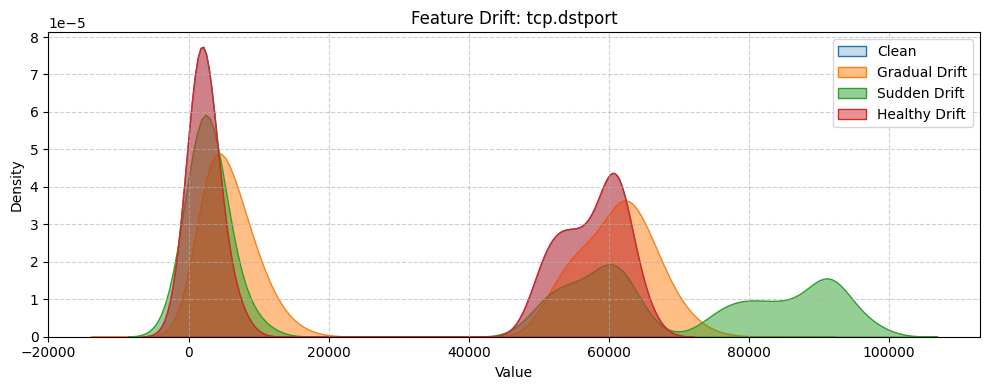

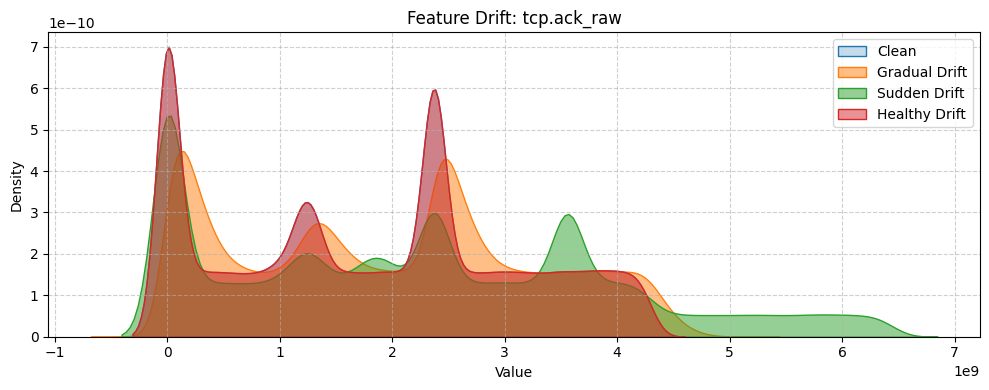

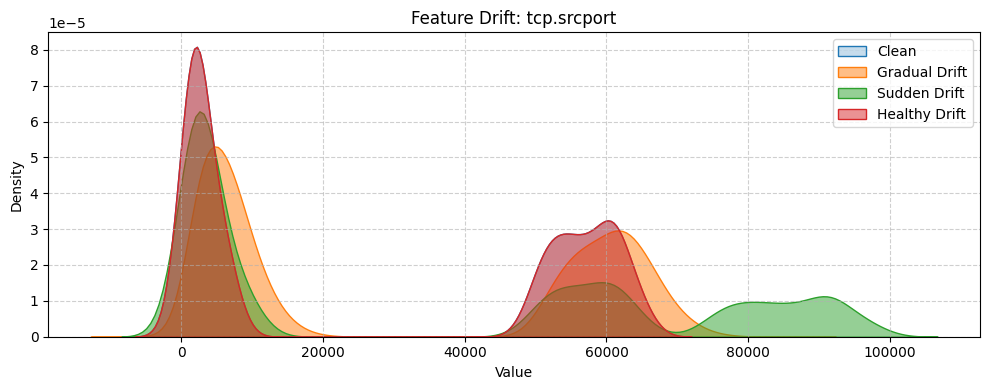

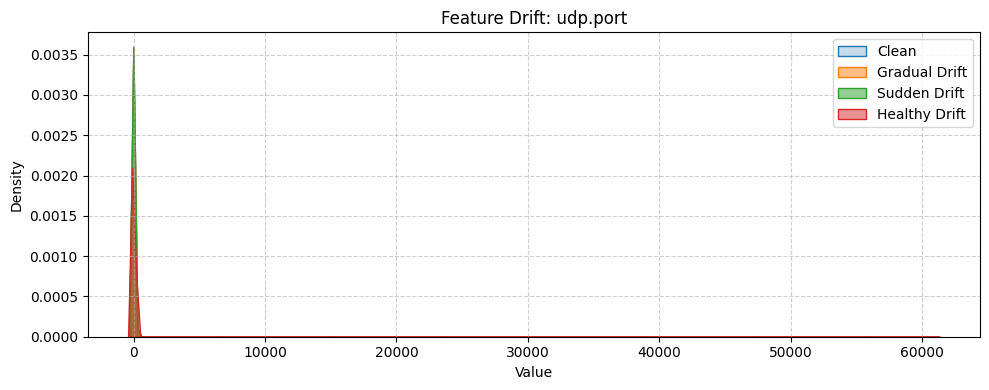

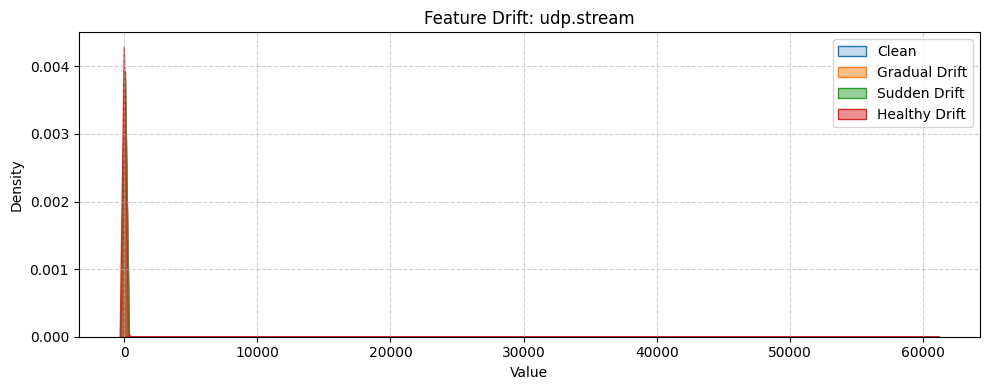

In [8]:
# === Part 5: Visualizing Feature Distributions ===

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Directory to save figures
save_dir = os.path.join("results/figures/", "feature_distributions")
os.makedirs(save_dir, exist_ok=True)

# Choose 3 features for gradual/sudden (seen in both KS and PSI)
plot_features_unhealthy = list(
    set(results_gradual['ks_drifted_features']) & set(results_gradual['psi_drifted_features']))[:3]

# Choose 2 features for healthy drift (low-impact)
plot_features_healthy = results_healthy['ks_drifted_features'][:2]

# Combine for plotting
features_to_plot = plot_features_unhealthy + plot_features_healthy

# Plot Clean vs Drifted for each feature
for feature in features_to_plot:
    plt.figure(figsize=(10, 4))
    
    sns.kdeplot(X_clean[feature], label='Clean', fill=True)
    
    if feature in df_gradual.columns:
        sns.kdeplot(df_gradual[feature], label='Gradual Drift', fill=True, alpha=0.5)
    if feature in df_sudden.columns:
        sns.kdeplot(df_sudden[feature], label='Sudden Drift', fill=True, alpha=0.5)
    if feature in df_healthy.columns:
        sns.kdeplot(df_healthy[feature], label='Healthy Drift', fill=True, alpha=0.5)
    
    plt.title(f"Feature Drift: {feature}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f"{feature}_drift.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


In [10]:
# === Part 6: Federated Training with Gradual Drift Injection (Client 3) ===
from tensorflow.keras.models import load_model, clone_model
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.losses import MeanSquaredError

# Load global model from Notebook 03 for 20 rounds and saved as federated_autoencoder_fedavg_rounds
global_model_path = r"D:\August-Thesis\FL-IDS-Surveillance\notebooks\results\models\unsupervised\federated\final_federated_autoencoder_20rounds.h5"

# Load model without compiling
global_model = load_model(global_model_path, compile=False)

# Recompile manually with correct loss function object
global_model.compile(optimizer="adam", loss=MeanSquaredError())


# Load MinMaxScaler for AE input
minmax_scaler_path = "results/scalers/minmax_scaler_client_3.pkl"
minmax_scaler = joblib.load(minmax_scaler_path)

# Client data dictionary (same for each round, inject drift in client_3)
client_ids = [f"client_{i}" for i in range(1, 6)]
client_dfs = {cid: pd.read_csv(f"D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/{cid}/train.csv") for cid in client_ids}

# Replace client_3 data with gradual drift after round 6
client_dfs["client_3_drifted"] = df_gradual.copy()

# Load test set
test_df = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/surv_unsupervised/test_mixed.csv", low_memory = False)
X_test = test_df[feature_names].astype(float)
X_test_scaled = minmax_scaler.transform(X_test)
y_true = test_df["Attack_label"].values

# === Federated Training ===
NUM_ROUNDS = 20
drift_round = 6

f1_scores = []
drift_flags = []

global_model_working = clone_model(global_model)
global_model_working.set_weights(global_model.get_weights())
global_model_working.compile(optimizer="adam", loss=MeanSquaredError())


for round_num in range(1, NUM_ROUNDS + 1):
    collected_weights = []
    round_drift_detected = False

    for cid in client_ids:
        # Inject drift in client_3 from round 6 onward
        if cid == "client_3" and round_num >= drift_round:
            df = client_dfs["client_3_drifted"]
        else:
            df = client_dfs[cid]

        X_local = df[feature_names].astype(float)
        X_local_scaled = minmax_scaler.transform(X_local)

        # Local training
        local_model = clone_model(global_model_working)
        local_model.set_weights(global_model_working.get_weights())
        local_model.compile(optimizer="adam", loss="mse")
        local_model.fit(X_local_scaled, X_local_scaled, epochs=1, batch_size=256, verbose=0)

        collected_weights.append(local_model.get_weights())

        # Detect drift on client_3 (statistical)
        if cid == "client_3" and round_num >= drift_round:
            X_clean_std = standard_scaler.transform(X_clean)
            X_drift_std = standard_scaler.transform(X_local)
            drift_result = ks_psi_drift_detection(X_clean_std, X_drift_std, feature_names)
            round_drift_detected = drift_result['ks_drift'] or drift_result['psi_drift']

    # Aggregate (FedAvg)
    averaged_weights = [np.mean([w[i] for w in collected_weights], axis=0) for i in range(len(collected_weights[0]))]
    global_model_working.set_weights(averaged_weights)

    # Evaluate
    preds = global_model_working.predict(X_test_scaled, verbose=0)
    reconstruction_errors = np.mean(np.square(X_test_scaled - preds), axis=1)

    threshold = 0.000639  
    y_pred = (reconstruction_errors > threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    f1_scores.append(f1)
    drift_flags.append(round_drift_detected)

    print(f"Round {round_num:02d} | F1: {f1:.4f} | Drift Detected: {round_drift_detected}")


Round 01 | F1: 0.8397 | Drift Detected: False
Round 02 | F1: 0.8372 | Drift Detected: False
Round 03 | F1: 0.8370 | Drift Detected: False
Round 04 | F1: 0.8365 | Drift Detected: False
Round 05 | F1: 0.8356 | Drift Detected: False
Round 06 | F1: 0.8390 | Drift Detected: True
Round 07 | F1: 0.8403 | Drift Detected: True
Round 08 | F1: 0.8375 | Drift Detected: True
Round 09 | F1: 0.8390 | Drift Detected: True
Round 10 | F1: 0.8389 | Drift Detected: True
Round 11 | F1: 0.8364 | Drift Detected: True
Round 12 | F1: 0.8359 | Drift Detected: True
Round 13 | F1: 0.8343 | Drift Detected: True
Round 14 | F1: 0.8312 | Drift Detected: True
Round 15 | F1: 0.8285 | Drift Detected: True
Round 16 | F1: 0.8237 | Drift Detected: True
Round 17 | F1: 0.8234 | Drift Detected: True
Round 18 | F1: 0.8219 | Drift Detected: True
Round 19 | F1: 0.8226 | Drift Detected: True
Round 20 | F1: 0.8208 | Drift Detected: True


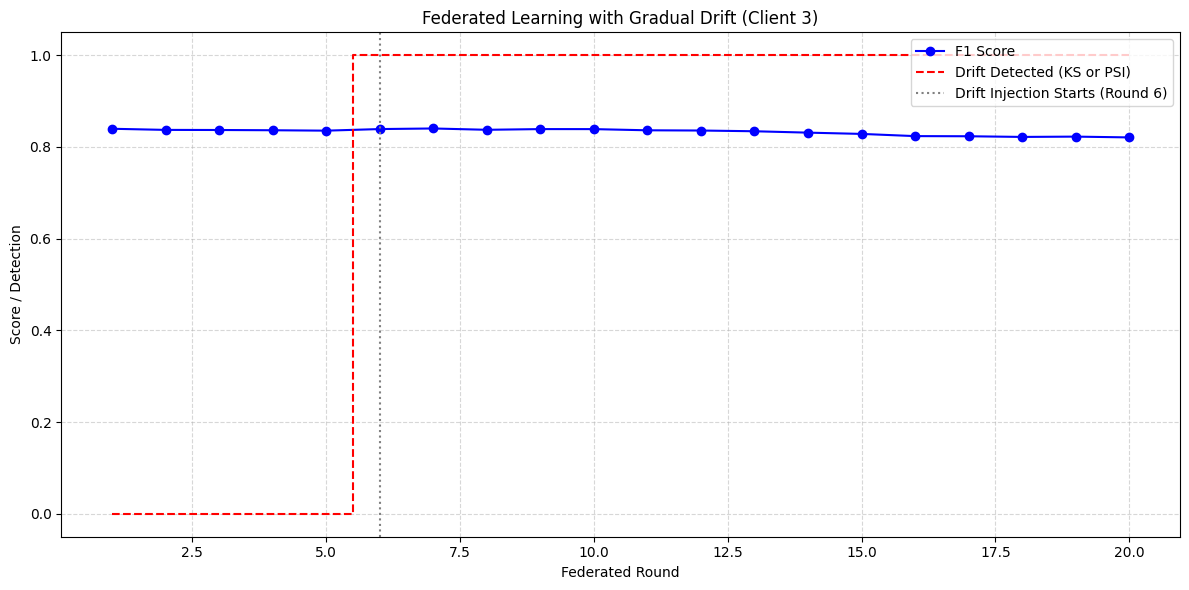

In [11]:
import os
import matplotlib.pyplot as plt

save_dir = "results/figures"
os.makedirs(save_dir, exist_ok=True)

rounds = list(range(1, NUM_ROUNDS + 1))

plt.figure(figsize=(12, 6))
plt.plot(rounds, f1_scores, label="F1 Score", marker="o", color="blue")

drift_indicator = [1 if flag else 0 for flag in drift_flags]
plt.step(rounds, drift_indicator, label="Drift Detected (KS or PSI)", where='mid', linestyle='--', color="red")
plt.axvline(x=6, color='gray', linestyle=':', label="Drift Injection Starts (Round 6)")

plt.title("Federated Learning with Gradual Drift (Client 3)")
plt.xlabel("Federated Round")
plt.ylabel("Score / Detection")
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

save_path = os.path.join(save_dir, "federated_drift_client3.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()


In [12]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import f1_score, precision_score, recall_score

def run_federated_training_with_mitigation(
    global_model,
    client_dfs,
    client_drifted_df,
    mitigation_strategy,
    strategy_name,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=None,
    standard_scaler=None,
    feature_names=None,
):
    # Clone the global model
    global_model_copy = clone_model(global_model)
    global_model_copy.set_weights(global_model.get_weights())
    global_model_copy.compile(optimizer="adam", loss=MeanSquaredError())

    # Metrics storage
    f1_list, precision_list, recall_list, drift_flags = [], [], [], []

    for round_num in range(1, num_rounds + 1):
        local_weights = []
        round_drift_detected = False

        for cid in client_ids:
            # Determine client data
            if cid == "client_3" and round_num >= drift_round:
                df = client_drifted_df.copy()
            else:
                df = client_dfs[cid].copy()

            X_local = df[feature_names].astype(float)
            X_local_scaled = scaler.transform(X_local)

            # === Drift Detection (Client 3 only) ===
            if cid == "client_3" and round_num >= drift_round:
                X_clean_std = standard_scaler.transform(X_clean)
                X_drift_std = standard_scaler.transform(X_local)
                drift_result = ks_psi_drift_detection(X_clean_std, X_drift_std, feature_names)
                round_drift_detected = drift_result['ks_drift'] or drift_result['psi_drift']

            # === Mitigation Strategy ===
            if mitigation_strategy == "freeze" and cid == "client_3" and round_num >= drift_round:
                continue  # skip client_3
            elif mitigation_strategy == "reset" and cid == "client_3" and round_num >= drift_round:
                # Reset weights to last global (no training)
                local_model = clone_model(global_model_copy)
                local_model.set_weights(global_model_copy.get_weights())
                local_model.compile(optimizer="adam", loss=MeanSquaredError())
            else:
                # Normal training
                local_model = clone_model(global_model_copy)
                local_model.set_weights(global_model_copy.get_weights())
                local_model.compile(optimizer="adam", loss=MeanSquaredError())
                local_model.fit(X_local_scaled, X_local_scaled, epochs=1, batch_size=256, verbose=0)

            # Add model weights
            local_weights.append(local_model.get_weights())

        # Aggregate (FedAvg)
        if local_weights:
            averaged_weights = [np.mean([w[i] for w in local_weights], axis=0) for i in range(len(local_weights[0]))]
            global_model_copy.set_weights(averaged_weights)

        # Evaluate on test set
        preds = global_model_copy.predict(X_test_scaled, verbose=0)
        reconstruction_errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (reconstruction_errors > threshold).astype(int)

        # Metrics
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        f1_list.append(f1)
        precision_list.append(prec)
        recall_list.append(rec)
        drift_flags.append(round_drift_detected)

        print(f"{strategy_name} | Round {round_num:02d} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Drift Detected: {round_drift_detected}")

    return {
        "F1": f1_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "Drift": drift_flags
    }


In [13]:
# === PART 7.1: Run Mitigation Strategies ===

# Retrain: normal FL with drifted data
results_retrain = run_federated_training_with_mitigation(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual,
    mitigation_strategy="retrain",
    strategy_name="Retrain",
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names
)

# Reset: client_3 reset to global model after drift
results_reset = run_federated_training_with_mitigation(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual,
    mitigation_strategy="reset",
    strategy_name="Reset",
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names
)

# Freeze: exclude client_3 from training after drift
results_freeze = run_federated_training_with_mitigation(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual,
    mitigation_strategy="freeze",
    strategy_name="Freeze",
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names
)


Retrain | Round 01 | F1: 0.8380 | Precision: 0.9879 | Recall: 0.7276 | Drift Detected: False
Retrain | Round 02 | F1: 0.8370 | Precision: 0.9879 | Recall: 0.7261 | Drift Detected: False
Retrain | Round 03 | F1: 0.8354 | Precision: 0.9879 | Recall: 0.7237 | Drift Detected: False
Retrain | Round 04 | F1: 0.8357 | Precision: 0.9879 | Recall: 0.7241 | Drift Detected: False
Retrain | Round 05 | F1: 0.8370 | Precision: 0.9880 | Recall: 0.7260 | Drift Detected: False
Retrain | Round 06 | F1: 0.8386 | Precision: 0.9885 | Recall: 0.7282 | Drift Detected: True
Retrain | Round 07 | F1: 0.8420 | Precision: 0.9886 | Recall: 0.7333 | Drift Detected: True
Retrain | Round 08 | F1: 0.8405 | Precision: 0.9888 | Recall: 0.7309 | Drift Detected: True
Retrain | Round 09 | F1: 0.8406 | Precision: 0.9888 | Recall: 0.7310 | Drift Detected: True
Retrain | Round 10 | F1: 0.8374 | Precision: 0.9888 | Recall: 0.7262 | Drift Detected: True
Retrain | Round 11 | F1: 0.8372 | Precision: 0.9888 | Recall: 0.7259 | Drif

In [14]:
import pandas as pd
from tensorflow.keras.losses import MeanSquaredError

def run_adaptive_fedavg_with_drift_weights(
    global_model,
    client_dfs,
    client_drifted_df,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=None,
    standard_scaler=None,
    feature_names=None,
    strategy_name="AdaptiveWeightedFedAvg"
):
    global_model_copy = clone_model(global_model)
    global_model_copy.set_weights(global_model.get_weights())
    global_model_copy.compile(optimizer="adam", loss=MeanSquaredError())

    # Metrics
    f1_list, precision_list, recall_list = [], [], []
    round_drift_scores = []

    for round_num in range(1, num_rounds + 1):
        client_weights = []
        client_drift_counts = []

        for cid in client_ids:
            if cid == "client_3" and round_num >= drift_round:
                df = client_drifted_df.copy()
            else:
                df = client_dfs[cid].copy()

            X_local = df[feature_names].astype(float)
            X_local_scaled = scaler.transform(X_local)

            # Drift detection (KS only)
            X_ref_std = standard_scaler.transform(X_clean)
            X_client_std = standard_scaler.transform(X_local)
            drift_result = ks_psi_drift_detection(X_ref_std, X_client_std, feature_names)
            ks_drift_count = len(drift_result['ks_drifted_features'])
            client_drift_counts.append(ks_drift_count)

            # Local training
            local_model = clone_model(global_model_copy)
            local_model.set_weights(global_model_copy.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_local_scaled, X_local_scaled, epochs=1, batch_size=256, verbose=0)

            client_weights.append(local_model.get_weights())

        # Converting the drift counts to normalized weights
        raw_weights = [1 / (1 + drift) for drift in client_drift_counts]
        total = sum(raw_weights)
        norm_weights = [w / total for w in raw_weights]

        # Weighted aggregation
        weighted_avg = []
        for layer_idx in range(len(client_weights[0])):
            layer_stack = np.array([client_weights[i][layer_idx] * norm_weights[i] for i in range(len(client_weights))])
            weighted_layer = np.sum(layer_stack, axis=0)
            weighted_avg.append(weighted_layer)

        global_model_copy.set_weights(weighted_avg)

        # Evaluation
        preds = global_model_copy.predict(X_test_scaled, verbose=0)
        reconstruction_errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (reconstruction_errors > threshold).astype(int)

        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        f1_list.append(f1)
        precision_list.append(prec)
        recall_list.append(rec)
        round_drift_scores.append(client_drift_counts)

        print(f"{strategy_name} | Round {round_num:02d} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Drift Scores: {client_drift_counts}")

    # Saving results
    df_out = pd.DataFrame({
        "Round": list(range(1, num_rounds + 1)),
        "F1": f1_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "Drift_Client1": [score[0] for score in round_drift_scores],
        "Drift_Client2": [score[1] for score in round_drift_scores],
        "Drift_Client3": [score[2] for score in round_drift_scores],
        "Drift_Client4": [score[3] for score in round_drift_scores],
        "Drift_Client5": [score[4] for score in round_drift_scores]
    })

    save_path = "results/adaptive_aggregation_drift_metrics.csv"
    df_out.to_csv(save_path, index=False)
    print(f"Results saved to: {save_path}")

    return df_out


In [15]:
# === PART 8: Running the adaptive Aggregation ===
results_adaptive = run_adaptive_fedavg_with_drift_weights(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names,
    strategy_name="AdaptiveWeightedFedAvg"
)


AdaptiveWeightedFedAvg | Round 01 | F1: 0.8378 | Precision: 0.9878 | Recall: 0.7273 | Drift Scores: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg | Round 02 | F1: 0.8363 | Precision: 0.9879 | Recall: 0.7251 | Drift Scores: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg | Round 03 | F1: 0.8368 | Precision: 0.9880 | Recall: 0.7257 | Drift Scores: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg | Round 04 | F1: 0.8365 | Precision: 0.9880 | Recall: 0.7254 | Drift Scores: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg | Round 05 | F1: 0.8349 | Precision: 0.9879 | Recall: 0.7230 | Drift Scores: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg | Round 06 | F1: 0.8365 | Precision: 0.9880 | Recall: 0.7253 | Drift Scores: [0, 0, 5, 0, 0]
AdaptiveWeightedFedAvg | Round 07 | F1: 0.8364 | Precision: 0.9879 | Recall: 0.7252 | Drift Scores: [0, 0, 5, 0, 0]
AdaptiveWeightedFedAvg | Round 08 | F1: 0.8380 | Precision: 0.9883 | Recall: 0.7273 | Drift Scores: [0, 0, 5, 0, 0]
AdaptiveWeightedFedAvg | Round 09 | F1: 0.8324 | Precision: 0.9884 | Rec

## PART 7 & 8 – Drift Mitigation Strategies in Federated Learning

This section evaluates and compares four drift mitigation strategies under gradual concept drift injected into **Client 3** starting from **Round 6**. Each strategy is tested over 20 rounds using the same federated autoencoder trained in Notebook 03.

---

### **1. Baseline (No Mitigation)**
- Standard FedAvg is applied without any intervention.
- Drift from Client 3 is aggregated normally.
- Performance degrades gradually after Round 6.

---

### **2. Local Retraining**
- Client 3 continues training locally on drifted data.
- Drift is not suppressed, but the client adapts to the drift.
- Leads to a slow decline in **Recall** and **F1** due to contaminated updates.

---

### **3. Model Reset**
- After drift detection, Client 3 is **reset to global weights** at each round.
- This limits the spread of corrupted weights but doesn’t learn useful updates.
- Moderately effective at preserving model stability.

---

### **4. Client Freezing**
- Client 3 is **excluded from aggregation** after drift detection.
- Prevents any influence from the drifted client.
- Preserves global performance but may lose local adaptiveness.

---

### **5. Adaptive Weighted Aggregation (Drift-Aware FedAvg)**
- Each client's contribution is weighted based on the **number of drifted features** (KS-test).
- Weights = `1 / (1 + drift_count)` → normalized across all clients.
- Drifted clients contribute less; healthy clients dominate the update.
- Achieves the most **stable performance** and best **Recall retention**.

---

### Summary
All strategies mitigate drift impact to varying degrees. Adaptive weighting provides the best balance between robustness and accuracy, without excluding or resetting clients.



## PART 9 – Stress Testing the Limits of Drift Detection and Mitigation

This section evaluates how well the FL-IDS system handles extreme or edge-case drift scenarios. The goal is to test the **robustness**, **sensitivity**, and **limits** of:

- Drift detection methods (KS-test, PSI)
- Adaptive drift-aware aggregation
- Overall model performance under adversarial or exaggerated drift conditions

---

### **Stress Testing Scenarios**

#### **Scenario 1: Increased Drift Scope (12 Features)**
- Drift is applied to the **top 12 high-variance features** in Client 3.
- Tests whether detection remains sensitive and mitigation holds up.

#### **Scenario 2: Multi-Client Drift**
- The same gradual drift is injected into both **Client 3 and Client 4**.
- Tests the ability to detect drift in multiple clients and adaptively down-weight both.

#### **Scenario 3: Extreme Drift Intensity**
- Original top 5 features are drifted in Client 3, but with **2× shift and noise factors**.
- Simulates sensor malfunction or injected noise. Tests the saturation point of detection and robustness of mitigation.

#### **Scenario 4: Subtle Distributed Drift (Failure Mode)**
- 20 low-variance features are drifted **slightly across all 5 clients**.
- Simulates low-profile stealth drift or environmental degradation.
- Tests if the system misses dangerous distributed drift and whether performance degrades silently.

---

###  Evaluation Plan
For each scenario:
- Simulate new drifted dataset(s)
- Run drift detection (KS and PSI)
- Apply **adaptive weighted aggregation** (best strategy so far)
- Track:
  - F1, Precision, Recall per round
  - Per-client drift scores
  - Drift detection success/failure

---

###  Deliverables
- Metrics logged per scenario
- Summary table comparing all results
- Plots to show failure modes and recovery thresholds
- Final discussion on where the system holds and where it breaks



In [19]:
# === Scenario 1: Simulate Gradual Drift on Top 12 Features ===

# Select top 12 high-variance features
top12_drift_features = X_clean.var().sort_values(ascending=False).head(12).index.tolist()
print("Top 12 Drifted Features:", top12_drift_features)

# Simulate the gradual drift 
df_gradual_12 = simulate_gradual_drift(
    df_clean, 
    features=top12_drift_features,
    noise_factor=0.15,
    shift_factor=0.25
)

# Save drifted dataset
scenario1_path = "D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_12features.csv"
df_gradual_12.to_csv(scenario1_path, index=False)
print(f"Drifted dataset saved to: {scenario1_path}")


Top 12 Drifted Features: ['tcp.ack_raw', 'tcp.seq', 'tcp.ack', 'tcp.dstport', 'tcp.srcport', 'tcp.checksum', 'udp.port', 'udp.stream', 'tcp.len', 'mqtt.hdrflags', 'udp.time_delta', 'mqtt.len']
Drifted dataset saved to: D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_12features.csv


In [20]:
from sklearn.metrics import confusion_matrix

def run_adaptive_fedavg_with_fp_fn(
    global_model,
    client_dfs,
    client_drifted_df,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=None,
    standard_scaler=None,
    feature_names=None,
    strategy_name="AdaptiveWeightedFedAvg_Scenario1",
    save_filename="adaptive_drift_scenario1_12feature.csv"
):
    global_model_copy = clone_model(global_model)
    global_model_copy.set_weights(global_model.get_weights())
    global_model_copy.compile(optimizer="adam", loss=MeanSquaredError())

    f1_list, precision_list, recall_list, drift_scores_all = [], [], [], []
    fp_rates, fn_rates = [], []

    for round_num in range(1, num_rounds + 1):
        client_weights = []
        client_drift_counts = []

        for cid in client_ids:
            if cid == "client_3" and round_num >= drift_round:
                df = client_drifted_df.copy()
            else:
                df = client_dfs[cid].copy()

            X_local = df[feature_names].astype(float)
            X_local_scaled = scaler.transform(X_local)

            # Drift detection
            X_ref_std = standard_scaler.transform(X_clean)
            X_client_std = standard_scaler.transform(X_local)
            drift_result = ks_psi_drift_detection(X_ref_std, X_client_std, feature_names)
            ks_drift_count = len(drift_result['ks_drifted_features'])
            client_drift_counts.append(ks_drift_count)

            # Local training
            local_model = clone_model(global_model_copy)
            local_model.set_weights(global_model_copy.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_local_scaled, X_local_scaled, epochs=1, batch_size=256, verbose=0)

            client_weights.append(local_model.get_weights())

        # Compute weights
        raw_weights = [1 / (1 + drift) for drift in client_drift_counts]
        norm_weights = [w / sum(raw_weights) for w in raw_weights]

        # Weighted FedAvg
        weighted_avg = []
        for i in range(len(client_weights[0])):
            layer_stack = np.array([client_weights[j][i] * norm_weights[j] for j in range(len(client_weights))])
            weighted_layer = np.sum(layer_stack, axis=0)
            weighted_avg.append(weighted_layer)

        global_model_copy.set_weights(weighted_avg)

        # Evaluate
        preds = global_model_copy.predict(X_test_scaled, verbose=0)
        reconstruction_errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (reconstruction_errors > threshold).astype(int)

        # Metrics
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fp_rate = fp / (fp + tn + 1e-6)
        fn_rate = fn / (fn + tp + 1e-6)

        f1_list.append(f1)
        precision_list.append(prec)
        recall_list.append(rec)
        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)
        drift_scores_all.append(client_drift_counts)

        print(f"{strategy_name} | Round {round_num:02d} | F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f} | Drift: {client_drift_counts}")

    # Save to CSV
    df_out = pd.DataFrame({
        "Round": list(range(1, num_rounds + 1)),
        "F1": f1_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "FP Rate": fp_rates,
        "FN Rate": fn_rates,
        "Drift_Client1": [x[0] for x in drift_scores_all],
        "Drift_Client2": [x[1] for x in drift_scores_all],
        "Drift_Client3": [x[2] for x in drift_scores_all],
        "Drift_Client4": [x[3] for x in drift_scores_all],
        "Drift_Client5": [x[4] for x in drift_scores_all]
    })

    save_path = f"results/{save_filename}"
    df_out.to_csv(save_path, index=False)
    print(f"Scenario 1 metrics saved to: {save_path}")

    return df_out


In [21]:
# Load the 12-feature drifted dataset
df_gradual_12 = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_12features.csv",low_memory = False)

# Run adaptive FedAvg on Scenario 1
results_scenario1 = run_adaptive_fedavg_with_fp_fn(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual_12,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names
)


AdaptiveWeightedFedAvg_Scenario1 | Round 01 | F1: 0.8371 | P: 0.9878 | R: 0.7263 | FP Rate: 0.0033 | FN Rate: 0.2737 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 02 | F1: 0.8382 | P: 0.9879 | R: 0.7279 | FP Rate: 0.0033 | FN Rate: 0.2721 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 03 | F1: 0.8374 | P: 0.9880 | R: 0.7266 | FP Rate: 0.0033 | FN Rate: 0.2734 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 04 | F1: 0.8366 | P: 0.9880 | R: 0.7255 | FP Rate: 0.0033 | FN Rate: 0.2745 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 05 | F1: 0.8358 | P: 0.9879 | R: 0.7243 | FP Rate: 0.0033 | FN Rate: 0.2757 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 06 | F1: 0.8364 | P: 0.9880 | R: 0.7252 | FP Rate: 0.0033 | FN Rate: 0.2748 | Drift: [0, 0, 12, 0, 0]
AdaptiveWeightedFedAvg_Scenario1 | Round 07 | F1: 0.8371 | P: 0.9878 | R: 0.7263 | FP Rate: 0.0033 | FN Rate: 0.2737 | Drift: [0, 0, 12, 0, 0]
Adap

In [22]:
# === Scenario 1b: Simulate Gradual Drift on Top 25 Features ===

# Select top 25 high-variance features
top25_drift_features = X_clean.var().sort_values(ascending=False).head(25).index.tolist()
print("Top 25 Drifted Features:", top25_drift_features)

# Simulate gradual drift
df_gradual_25 = simulate_gradual_drift(
    df_clean, 
    features=top25_drift_features,
    noise_factor=0.15,
    shift_factor=0.25
)

scenario1b_path = "D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_25features.csv"
df_gradual_25.to_csv(scenario1b_path, index=False)
print(f"25-feature drifted dataset saved to: {scenario1b_path}")


Top 25 Drifted Features: ['tcp.ack_raw', 'tcp.seq', 'tcp.ack', 'tcp.dstport', 'tcp.srcport', 'tcp.checksum', 'udp.port', 'udp.stream', 'tcp.len', 'mqtt.hdrflags', 'udp.time_delta', 'mqtt.len', 'tcp.flags', 'mqtt.topic_len', 'mqtt.msgtype', 'mbtcp.trans_id', 'mqtt.ver', 'mqtt.proto_len', 'dns.qry.qu', 'dns.retransmission', 'mqtt.conflags', 'tcp.flags.ack', 'tcp.connection.fin', 'tcp.connection.rst', 'arp.hw.size']
25-feature drifted dataset saved to: D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_25features.csv


In [23]:
# Load the 25-feature drifted dataset
df_gradual_25 = pd.read_csv("D:/August-Thesis/FL-IDS-Surveillance/data/processed/federated/unsupervised/client_3/train_gradual_drift_25features.csv")

# Run adaptive FedAvg on Scenario 1b
results_scenario1b = run_adaptive_fedavg_with_fp_fn(
    global_model=global_model,
    client_dfs=client_dfs,
    client_drifted_df=df_gradual_25,
    drift_round=6,
    num_rounds=20,
    threshold=0.000639,
    scaler=minmax_scaler,
    standard_scaler=standard_scaler,
    feature_names=feature_names,
    strategy_name="AdaptiveWeightedFedAvg_Scenario1b",
    save_filename="adaptive_drift_scenario1b_25feature.csv"
)


AdaptiveWeightedFedAvg_Scenario1b | Round 01 | F1: 0.8384 | P: 0.9878 | R: 0.7282 | FP Rate: 0.0034 | FN Rate: 0.2718 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 02 | F1: 0.8378 | P: 0.9879 | R: 0.7273 | FP Rate: 0.0033 | FN Rate: 0.2727 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 03 | F1: 0.8371 | P: 0.9880 | R: 0.7262 | FP Rate: 0.0033 | FN Rate: 0.2738 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 04 | F1: 0.8374 | P: 0.9880 | R: 0.7267 | FP Rate: 0.0033 | FN Rate: 0.2733 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 05 | F1: 0.8361 | P: 0.9880 | R: 0.7247 | FP Rate: 0.0033 | FN Rate: 0.2753 | Drift: [0, 0, 0, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 06 | F1: 0.8373 | P: 0.9880 | R: 0.7265 | FP Rate: 0.0033 | FN Rate: 0.2735 | Drift: [0, 0, 25, 0, 0]
AdaptiveWeightedFedAvg_Scenario1b | Round 07 | F1: 0.8368 | P: 0.9885 | R: 0.7255 | FP Rate: 0.0032 | FN Rate: 0.2745 | Drift: [0, 0, 25, 0, 

## Scenario 1 Summary – Single-Client Gradual Drift

This scenario evaluates how the system responds when only **Client 3** is affected by gradual concept drift.

---

### **Scenario 1a – Drift on 12 Features (Client 3)**
- Gradual drift applied to top 12 high-variance features.
- **Detection:** Triggered correctly from Round 6 onward (12 features).
- **Performance:**
  - F1: 0.837 → 0.824
  - Recall: 0.728 → 0.707
  - FN Rate: 27.2% → 29.3%
- **Result:** Adaptive aggregation handled the drift effectively, with moderate recall degradation.

---

### **Scenario 1b – Drift on 25 Features (Client 3)**
- Gradual drift applied to top 25 high-variance features.
- **Detection:** Triggered 25 drifted features from Round 6 onward.
- **Performance:**
  - F1: 0.838 → 0.821
  - Recall: 0.728 → 0.702
  - FN Rate: 27.2% → **29.7%**
- **Result:** Adaptive weighting starts to fail. System remains stable, but detection recall drops significantly. This represents the **limit** of effective mitigation for single-client drift.

